In [87]:
import pandas as pd
import xgboost as xgb
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

target_col = "label"  # "status"
ok_val = 1  # "OK"


df = pd.read_csv("train.csv")
to_drop = ["physical_part_id", "message_timestamp"]
for c in df.columns:
    if df[c].isna().all():
        to_drop.append(c)
df = df.drop(columns=to_drop)
target = df[target_col] == ok_val
df = df.drop(columns=[target_col])
categorical_features = [c for c in df.columns if "sensor" not in c]
df = pd.get_dummies(df, columns=categorical_features)
df.head()


,s6_sensor0_millimeter_step1,s8_sensor0_millimeter_step1,s8_sensor1_millimeter_step1,s7_sensor0_newton_step1,s9_sensor0_kilonewton_step1,s7_sensor1_mikrometer_step1,s0_sensor0_kilonewton_step3,s2_sensor0_millimeter_step1,s9_sensor1_sekunden (zeit)_step1,s8_sensor2_millimeter_step1,...,physical_part_type_type4,weekday_Friday,weekday_Monday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,shift_Fruehschicht,shift_Nachtschicht,shift_Spaetschicht
0,4606.469076,20.936714,390.550800,8856.466834,36.836737,32226.284706,NaN,19.696395,1056.249745,7.556479,...,False,False,False,False,False,True,False,True,False,False
1,4606.469076,18.293964,378.279734,8860.946584,36.836737,32700.200657,NaN,17.763653,1056.249745,7.119582,...,False,True,False,False,False,False,False,True,False,False
2,5886.043819,20.944510,428.742769,8849.747208,36.836737,32429.391542,-53.537243,19.582187,1056.249745,9.377910,...,False,False,False,False,False,True,False,True,False,False
3,4606.469076,18.475864,373.095553,8845.267457,36.836737,32564.796100,NaN,18.238053,1056.249745,7.541095,...,False,False,False,False,True,False,False,True,False,False
4,4606.469076,19.801137,382.829679,8847.507333,36.836737,33309.521166,NaN,19.178068,1013.999755,8.282590,...,False,False,True,False,False,False,False,False,False,True


In [88]:
target.mean()


0.9492512891709639

In [89]:
# Take 90% of data for training
df_train = df.sample(frac=0.9, random_state=42)
df_val = df.drop(df_train.index)
target_train = target.iloc[df_train.index]
target_val = target.iloc[df_val.index]

print(df_train.shape, df_val.shape)


(36302, 365) (4034, 365)


In [90]:
# for it, col in enumerate(df_train.columns):
#     df_train[col + "_nan"] = df_train[col].isna()
#     df_val[col + "_nan"] = df_val[col].isna()
#     if it % 10 == 0:
#         df_train = df_train.copy()
#         df_val = df_val.copy()
X_train = df_train.values
y_train = target_train.values
X_val = df_val.values
y_val = target_val.values

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)


(36302, 365) (36302,) (4034, 365) (4034,)


In [91]:
imputer = SimpleImputer(strategy="constant", fill_value=0)
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)


In [92]:
xgb_tree = xgb.XGBClassifier()
lgbm_tree = LGBMClassifier()
catboost_tree = CatBoostClassifier()
logreg = LogisticRegression()
mlp = MLPClassifier()
tree = VotingClassifier(
    estimators=[
        ("xgb", xgb_tree),
        ("lgbm", lgbm_tree),
        ("catboost", catboost_tree),
        ("logreg", logreg),
        ("mlp", mlp),
    ],
    voting="soft",
)
tree.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 34483, number of negative: 1819
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40308
[LightGBM] [Info] Number of data points in the train set: 36302, number of used features: 358
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.949893 -> initscore=2.942180
[LightGBM] [Info] Start training from score 2.942180
Learning rate set to 0.047756
0:	learn: 0.6316003	total: 11.4ms	remaining: 11.4s
1:	learn: 0.5774923	total: 22.2ms	remaining: 11.1s
2:	learn: 0.5305680	total: 33ms	remaining: 11s
3:	learn: 0.4896012	total: 42.9ms	remaining: 10.7s
4:	learn: 0.4531275	total: 53.3ms	remaining: 10.6s
5:	learn: 0.4215512	total: 64.7ms	remaining: 10.7s
6:	learn: 0.3937391	total: 75ms	remaining: 10.6s
7:	learn: 0.3698040	total: 86.8ms	remaining: 10.8s
8:	learn: 0.3482827	total: 98ms	remaining: 10.8s
9:	learn: 0.3301292	total:

/Users/mike/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('lgbm', LGBMClassifier()),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x17db0ece0>),
                             ('logreg', LogisticRegression()),
                             ('mlp', MLPClassifier())],
                 voting='soft')

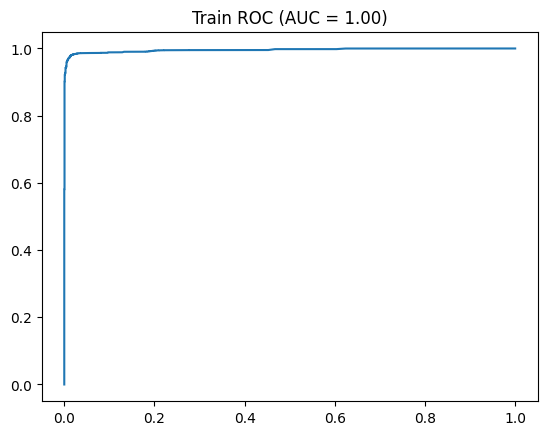

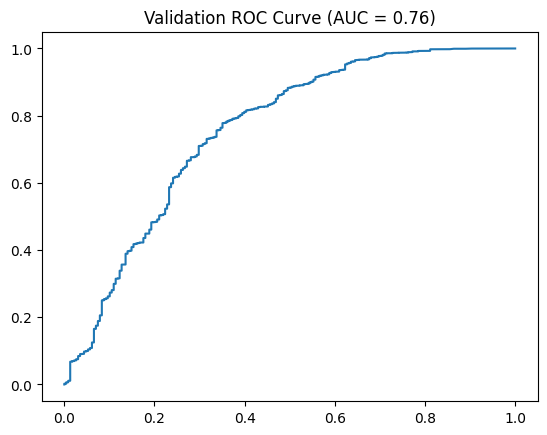

In [93]:
# Plot ROC curve on train
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve

y_pred = tree.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
roc_auc = auc(fpr, tpr)
plt.title(f"Train ROC (AUC = {roc_auc:.2f})")
plt.plot(fpr, tpr)
plt.show()

y_pred = tree.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
plt.title(f"Validation ROC Curve (AUC = {roc_auc:.2f})")
plt.plot(fpr, tpr)
plt.show()


In [94]:
test_df = pd.read_csv("test.csv")
test_df = test_df.drop(columns=to_drop)
test_df = pd.get_dummies(test_df, columns=categorical_features)
test_df.head()

X_test = test_df.values
X_test = imputer.transform(X_test)
y_pred = tree.predict_proba(X_test)[:, 1]

print(y_pred.shape)
print(y_pred[:10])


(4482,)
[0.98965732 0.96067467 0.97962544 0.98161941 0.98138902 0.96811505
 0.70817375 0.98382155 0.98352614 0.96672886]


In [68]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission["label"] = y_pred
sample_submission.to_csv("submission.csv", index=False)


In [69]:
print(len(test_df), len(sample_submission))


4482 4482
